# Origin and explanations: 

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf 

import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

if int(tf.__version__[0]) > 1:    
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
    from tensorflow.keras import regularizers
else:
    from keras.models import Model, load_model
    from keras.layers import Input, Dense
    from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
    from keras import regularizers   
    
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

In [2]:
df = pd.read_csv("data/creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [4]:
df.isnull().values.any()

False

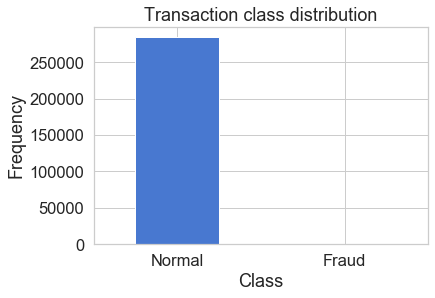

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

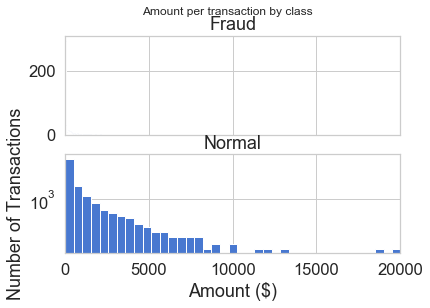

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

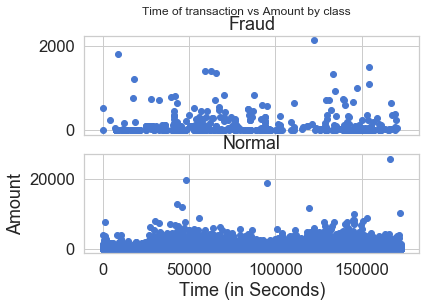

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Autoencoder:

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [13]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [14]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [15]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [19]:
input_dim = X_train.shape[1]
encoding_dim = 50

In [20]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l2(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [21]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

mc_callback = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tb_callback = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es_callback = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=5, 
                            verbose=2, 
                            mode='auto', 
                            baseline=None, 
                            restore_best_weights=False)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[mc_callback, tb_callback, es_callback]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 12s 53us/sample - loss: 0.6631 - accuracy: 0.7947 - val_loss: 0.6665 - val_accuracy: 0.8502
Epoch 2/100
227451/227451 [==============================] - 12s 51us/sample - loss: 0.6220 - accuracy: 0.8728 - val_loss: 0.6535 - val_accuracy: 0.8908
Epoch 3/100
227451/227451 [==============================] - 12s 51us/sample - loss: 0.6165 - accuracy: 0.8853 - val_loss: 0.6418 - val_accuracy: 0.9175
Epoch 4/100
227451/227451 [==============================] - 12s 51us/sample - loss: 0.6059 - accuracy: 0.9156 - val_loss: 0.6429 - val_accuracy: 0.9324
Epoch 5/100
227451/227451 [==============================] - 12s 51us/sample - loss: 0.6039 - accuracy: 0.9230 - val_loss: 0.6434 - val_accuracy: 0.9250
Epoch 6/100
227451/227451 [==============================] - 12s 51us/sample - loss: 0.6035 - accuracy: 0.9244 - val_loss: 0.6400 - val_accuracy: 0.9124
Epoch 7/100
227451/227451 [====

In [22]:
# autoencoder = load_model('model.h5')

# Evaluation

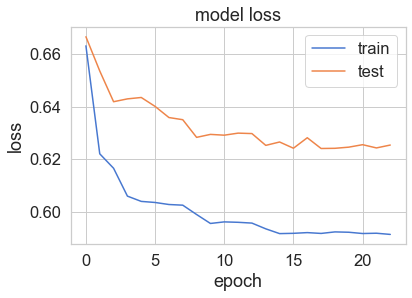

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [24]:
predictions = autoencoder.predict(X_test)

In [25]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [26]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.625045,0.001720
std,3.127769,0.041443
min,0.024239,0.000000
25%,0.179081,0.000000
50%,0.308073,0.000000
75%,0.513386,0.000000
max,244.611744,1.000000


## Reconstruction error without fraud

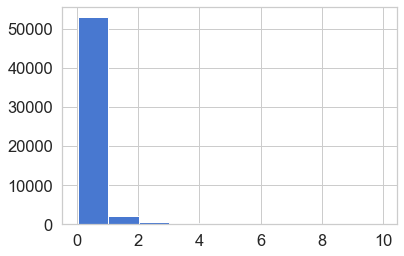

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

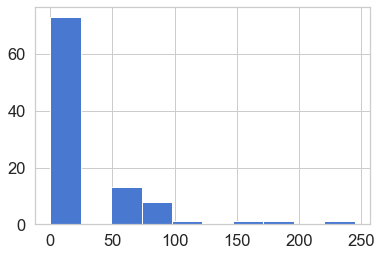

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [29]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

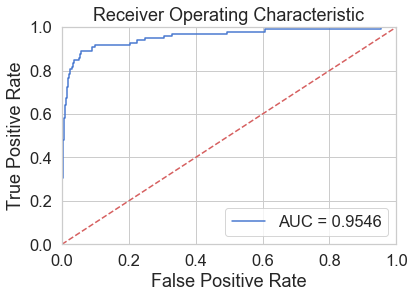

In [30]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

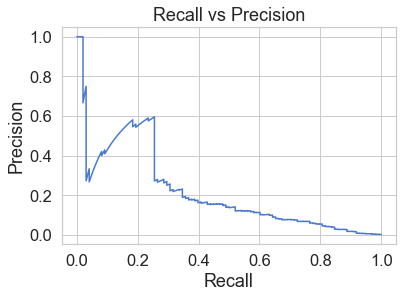

In [31]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

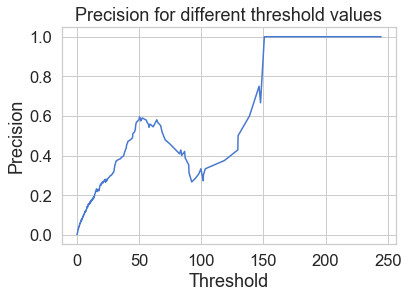

In [32]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

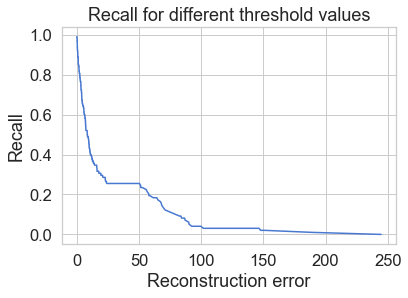

In [33]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## Prediction


In [34]:
threshold = 2.9

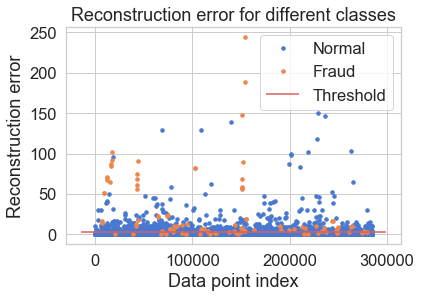

In [35]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

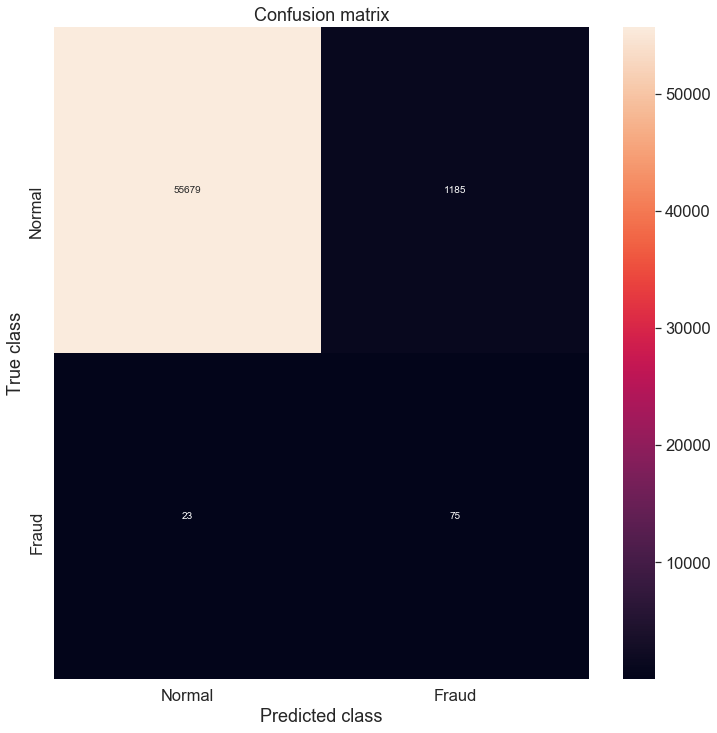

In [36]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)